# Modelling to Infer Void Parameters

### Current features:
- infers alpha and M* Schechter params
    - adding numerical interation to deal with alpha $\ge$ 1
- building non-parametric density function
    - currently sampling splines from uniform dist, then exponentiating to get $\rho(r)$ points
    - these points are then used to calculate shell masses which are then normalised
    - it should be noted that currently the model only constrains the $\rho(r)$ nodes up to a multiplicative constant
- selection correction included, with fine integration grid
    - introduce variable grid density to improve speed
- infers latent params, mag and comoving dist, for each galaxy observed

In [1]:
import numpy as np
import math
import pandas as pd
from scipy import integrate, optimize
import scipy as sp
import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_median, init_to_value
from jax import random, jit
from jax import numpy as jnp
from jax import vmap
from jaxopt import Bisection
# import arviz as az
from scipy.special import gammaincinv
from jax.scipy.special import gamma, gammaincc, gammainc, gammaln
from scipy.interpolate import interp1d
import pickle
import sys
from jax import numpy as jnp
from quadax import cumulative_simpson
from jax.scipy.stats.norm import logcdf as norm_logcdf

/Users/noahpierce/miniforge3/envs/jax_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For use on cluster

In [ ]:
from mpi4py import MPI

# Set up MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()   # This process's ID
size = comm.Get_size()   # Total processes

### Numerical integration of Schechter

In [2]:
## Global faint and bright magnitude limits
# -22.0 +- 25, selection integral needs wide lims
M_BRIGHT = -47.0
M_FAINT = 3.0

LOG10 = jnp.log(10.0)

def _log_trapz_exp(logf, x):
    """Compute log ∫ exp(logf(x)) dx stably."""
    m = jnp.max(logf)
    return m + jnp.log(jnp.trapezoid(jnp.exp(logf - m), x))

def schechter_log_norm_L(alpha, M_star, M_abs_Sun,
                         M_bright=M_BRIGHT, M_faint=M_FAINT,
                         ngrid=1024):
    """
    log I_L where I_L = ∫_{Lmin}^{Lmax} (L/L*)^{-alpha} exp(-L/L*) dL
    """
    # log L = -0.4 ln(10) (M - M_sun)
    logL_star = -0.4 * LOG10 * (M_star - M_abs_Sun)
    logL_min  = -0.4 * LOG10 * (M_faint  - M_abs_Sun)   # faint -> small L
    logL_max  = -0.4 * LOG10 * (M_bright - M_abs_Sun)   # bright -> large L

    logL = jnp.linspace(logL_min, logL_max, ngrid)
    x = jnp.exp(logL - logL_star)                       # L/L*
    log_shape = -alpha * (logL - logL_star) - x         # log[(L/L*)^{-a} e^{-L/L*}]

    # dL = L dlogL => integrand in logL is exp(log_shape + logL)
    log_integrand = log_shape + logL
    return _log_trapz_exp(log_integrand, logL)


def log_pdf_LF_trunc(M, alpha, M_star, M_abs_Sun, log_norm_L,
                     M_bright=M_BRIGHT, M_faint=M_FAINT):
    """
    Normalised Schechter PDF for range [M_bright, M_faint],
    allows alpha > 1
    """
    logL = -0.4 * jnp.log(10) * (M - M_abs_Sun)
    logL_star = -0.4 * jnp.log(10) * (M_star - M_abs_Sun)

    x = jnp.exp(logL - logL_star)   # L/L*
    log_phi_L = -alpha * (logL - logL_star) - x - log_norm_L

    # dL/dM = 0.4 * ln(10) * L
    log_jac = jnp.log(0.4 * LOG10) + logL
    
    in_support = (M >= M_bright) & (M <= M_faint)
    return jnp.where(in_support, log_phi_L + log_jac, -jnp.inf)

def schechter_inv_cdf_trunc(alpha, L_star, M_abs_Sun, M_bright=M_BRIGHT, M_faint=M_FAINT, ngrid=20000):
    """
    Returns a function inv(u) that maps u~U(0,1) -> L following
    truncated Schechter: f(L) ∝ (L/L*)^{-alpha} exp(-L/L*)
    on [Lmin, Lmax].
    """
    logL_min = -0.4 * LOG10 * (M_faint  - M_abs_Sun)
    logL_max = -0.4 * LOG10 * (M_bright - M_abs_Sun)

    logL = np.linspace(logL_min, logL_max, ngrid)
    L = np.exp(logL)

    # log f(L) up to a constant: -alpha*log(L/L*) - L/L*
    logf = -alpha * (logL - np.log(L_star)) - (L / L_star)

    # build CDF in logL space; note dL = L dlogL so add +logL (Jacobian)
    log_integrand = logf + logL
    log_integrand -= log_integrand.max()
    w = np.exp(log_integrand)

    # cumulative trapezoid in logL
    dlogL = np.diff(logL)
    cdf = np.cumsum(0.5 * (w[1:] + w[:-1]) * dlogL)
    cdf = np.concatenate([[0.0], cdf])
    cdf /= cdf[-1]

    def inv(u):
        return np.exp(np.interp(u, cdf, logL))

    return inv

    


### Functions

In [3]:
# inverse cdf
# input random no. for mass output
# def schechter_cdf_inv(u, alpha, L_star):
    
#     """
#     Inverse CDF of the Schechter function. Returns L based on u and Schechter parameters
    
#     0 <= u <= 1, alpha and L_star should be scalars
#     """
    
#     return gammaincinv(1-alpha, u) * L_star


# comoving distance from redshift
def redshift_to_dist(z, c, omega_m):
    
    """
    Takes inputs: redshift, c, H0, and matter density param
    Outputs: comoving distance
    """
    
    return (c / 100) * (z - 0.75 * omega_m * z**2)


# redshift from comoving distance
def dc_to_redshift(D_c, c, omega_m):
    
    """
    Takes inputs: comoving distance (in Mpc/h), c, and matter density param
    Outputs: redshift
    """
    
    D = (D_c * 100) / c
    return (1 - jnp.sqrt(1 - 3 * omega_m * D)) / (1.5 * omega_m)


# interpolation for non-parametric functions
def f_of_r(r, f_pts):
    """
    Interpolates f(r) for given spline points (f_pts)
    """
            
    # clip r to ensure within min/max of r_points
    r_clipped = jnp.clip(r, r_points[0], r_points[-1])
    return jnp.interp(r_clipped, r_points, f_pts)



### Selection correction functions

In [4]:
def dc2mu(dc):
    """Convert distance in Mpc to distance modulus."""
    z = dc_to_redshift(dc, c, omega_m)
    return 5 * jnp.log10(dc * (1 + z)) + 25

def mu2r(mu):
    """Convert distance modulus to distance in Mpc."""
    return 10 ** ((mu - 25) / 5)


def simpson2d(f_val, x_grid, y_grid):
    """Evaluate a 2D integral using Simpson's rule."""
    inner = cumulative_simpson(f_val, x=y_grid, axis=1, initial=0.0)
    outer = cumulative_simpson(inner, x=x_grid, axis=0, initial=0.0)
    return outer[-1, -1]


# def log_pdf_LF(M, alpha, M_star, M_abs_Sun):
#     """Simple Gaussian-like luminosity function. Replace with Schechter or other."""
#     norm = gamma(1 - alpha) * jnp.exp(-0.4*jnp.log(10)*(M_star - M_abs_Sun))
#     Ln_L_by_Lstar = -0.4*jnp.log(10)*(M - M_star)
#     log_pdf_L = -alpha * Ln_L_by_Lstar - jnp.exp(Ln_L_by_Lstar) - jnp.log(norm) #Wrt L
#     log_pdf_M = log_pdf_L + jnp.log(0.4*jnp.log(10)) - 0.4*jnp.log(10)*(M - M_abs_Sun) #Wrt M
#     return log_pdf_M



def log_integrand_p_det(M, dc, M_star, alpha, r_vals, pdf_vals, mlim, m_err, M_abs_Sun, log_norm_L):
    """Logarithmic integrand for the detection probability."""
    
    app_mag = M + dc2mu(dc)
    x = (mlim - app_mag) / m_err
    
    #Radial distribution.
    
    inv_pdf = jnp.interp(dc, r_vals, pdf_vals)
    
    ln_prior_dc = jnp.log(inv_pdf)
    
    return norm_logcdf(x) + ln_prior_dc + log_pdf_LF_trunc(M, alpha, M_star, M_abs_Sun, log_norm_L)




### Additional functions for interpolated log normal

In [5]:
# -------------------------
# Analytic integral of r^2 * linear function
# -------------------------
def int_r2_linear(A, B, a, b):
    # integral of r^2 * (A + B r) dr
    return A * (b**3 - a**3) / 3.0 + B * (b**4 - a**4) / 4.0

# -------------------------
# Compute mass integral over each shell from node values
# -------------------------
def compute_shell_masses(r_nodes, edges, rho_nodes):
    n_shells = edges.shape[0] - 1
    n_nodes = r_nodes.shape[0]
    M = jnp.zeros((n_shells, n_nodes))

    for i in range(n_shells):
        a, b = edges[i], edges[i + 1]

        for j in range(n_nodes):
            # left half of linear hat
            if j > 0:
                s0, s1 = r_nodes[j-1], r_nodes[j]
                lo = jnp.maximum(a, s0)
                hi = jnp.minimum(b, s1)
                cond = hi > lo
                denom = s1 - s0 + 1e-12
                A = -s0 / denom
                B = 1.0 / denom
                M = M.at[i,j].set(M[i,j] + jnp.where(cond, int_r2_linear(A, B, lo, hi), 0.0))

            # right half of linear hat
            if j < n_nodes - 1:
                s0, s1 = r_nodes[j], r_nodes[j+1]
                lo = jnp.maximum(a, s0)
                hi = jnp.minimum(b, s1)
                cond = hi > lo
                denom = s1 - s0 + 1e-12
                A = s1 / denom
                B = -1.0 / denom
                M = M.at[i,j].set(M[i,j] + jnp.where(cond, int_r2_linear(A, B, lo, hi), 0.0))

    # compute shell masses
    shell_masses = M @ rho_nodes
    return shell_masses

# -------------------------
# Build normalized PDF and CDF on grid
# -------------------------
def build_pdf_cdf(r_nodes, edges, rho_nodes, r_grid):
    # compute shell masses for exact normalization
    shell_masses = compute_shell_masses(r_nodes, edges, rho_nodes)
    total_mass = jnp.sum(shell_masses)
    shell_mass_norm = shell_masses / total_mass

    # linear interpolation of rho
    rho_grid = jnp.interp(r_grid, r_nodes, rho_nodes)

    # PDF = r^2 * rho(r) / total_mass
    pdf_grid = r_grid**2 * rho_grid / total_mass
    # print('pdf norm', jnp.trapezoid(pdf_grid, r_grid))

    # CDF via cumulative trapezoid
    dr = r_grid[1] - r_grid[0]
    cdf_grid = jnp.cumsum(pdf_grid) * dr
    # print('cdf final val = ', cdf_grid[-1])
    cdf_grid = cdf_grid / cdf_grid[-1]

    return pdf_grid, cdf_grid, shell_mass_norm, rho_grid, total_mass

# -------------------------
# Inverse CDF sampling
# -------------------------
def inv_cdf_sample(r_grid, cdf_grid, u):
    """
    u: uniform random values [0,1]
    returns r samples
    """
    return jnp.interp(u, cdf_grid, r_grid)

### Model for HMC

In [6]:


def model(app_mag_obs, m_err, z_obs, z_err):
    

    # Priors
    dc_max_MCMC = dc_max_ground
    alpha = numpyro.sample("alpha", dist.Uniform(.5, 2.0))
    M_star = numpyro.sample("M_star", dist.Uniform(-23.0, -21.0))
    # concentration = jnp.ones(n_splines)
    # shell_mass = numpyro.sample("shell_mass", dist.Dirichlet(concentration))
    
    # # convert sampled shell masses to rho(r) spline points
    # rho_pts = shell_mass / shell_weights
    # numpyro.deterministic("f_pts", rho_pts)

    M_abs_Sun = M_abs_Sun_ground

    log_norm_L = schechter_log_norm_L(alpha, M_star, M_abs_Sun)

    sigma_f = 1.0   # std dev on log(rho)

    # log rho at spline knots
    f = numpyro.sample("f_pts", dist.Normal(0.0, sigma_f).expand([n_splines]))

    rho_pts = jnp.exp(f)
    
    # computing volume pdf for sampled spline points
    r_vals = jnp.linspace(0, dc_max_ground, 10000)
    
    pdf_grid, cdf_grid, shell_mass, rho_grid, total_mass = build_pdf_cdf(r_points, edges, rho_pts, r_vals)

    
    numpyro.deterministic("rho_pts", rho_pts)
    numpyro.deterministic("shell_mass", shell_mass)

    
    # calculating phi_star for each point in chain
    phi_star = N_obs / (gamma(1 - alpha) * abs(M_star))
    numpyro.deterministic("phi_star", phi_star)
    
    # mag selection correction
    #M_star = M_abs_Sun - 2.5*jnp.log10(L_star)
    M_min = M_BRIGHT
    M_max = M_FAINT
    M_grid = jnp.linspace(M_min, M_max, 1001)


    dc_min = 1e-5
    dc_max = dc_max_MCMC

    dc_grid = jnp.linspace(dc_min, dc_max, 1001)

    mlim = 18
    m_err = 0.05
    
    X, Y = jnp.meshgrid(M_grid, dc_grid, indexing='ij')
    log_integrand = log_integrand_p_det(X, Y, M_star, alpha, r_vals, pdf_grid, mlim, m_err, M_abs_Sun, log_norm_L)


    # This is p(S = 1 | Lambda) from the Overleaf notation.
    p_det = simpson2d(jnp.exp(log_integrand), M_grid, dc_grid)
    numpyro.factor("selection_effect", -N_obs * jnp.log(p_det))

    
    # plate over galaxies
    with numpyro.plate("data", N_obs):
        
        # sample absolute magnitude and comoving distance
        M_true = numpyro.sample("M_true", dist.Uniform(M_BRIGHT, M_FAINT))
        d_c_true = numpyro.sample("d_c_true", dist.Uniform(0, dc_max_MCMC))
        

        # apply volume prior
        inv_pdf = jnp.interp(d_c_true, r_vals, pdf_grid)
        log_prior = jnp.log(inv_pdf)
        
        numpyro.factor("volume_prior", log_prior)
        
        # compute redshift from comoving dist
        z_true = dc_to_redshift(d_c_true, c, omega_m)
        
        # likelihood term for redshift
        numpyro.sample("z_likelihood", dist.Normal(z_true, z_err), obs=z_obs)
        
        # compute luminosity distance
        d_L = (1 + z_true) * d_c_true
        
        # predict app mag from abs mag and lum dist
        m_model = M_true + 5 * jnp.log10(d_L) + 25 # magnitude in units related to h
        
        
        # apply Schechter prior on M_true
        numpyro.factor("M_true_prior", log_pdf_LF_trunc(M_true, alpha, M_star, M_abs_Sun, log_norm_L))
        
        # likelihood term for apparent magnitude
        numpyro.sample("m_obs", dist.Normal(m_model, m_err), obs=app_mag_obs)
        
        

### MPI setup

In [7]:
N_runs = 1
alpha_results = []
L_star_results = []
phi_star_results = []
rho_pts_results = []
shell_m_results = []

alpha_truths = []
M_star_truths = []
rho_pts_truths = []
shell_m_truths =[]

### Mock generation and sampling

- Loop for purpose of MPI
- MPI data storage at end

In [8]:
np.random.seed(0)


# set params
alpha = np.random.uniform(.5, 2.0)
L_star = 10**np.random.uniform(6, 6.8)
N_tot = 3000000
N_obs_target = 4000
dc_max_ground = 2000
dc_max_inv_ground = 1.0/dc_max_ground
omega_m = 0.3
c = 2.998 * 10**5
H_0 = 70
h = H_0 / 100

M_abs_Sun_ground = -6.0 #Look up for relevant filter from Willmer_2018 (ApJS, 236, 47) or similar
M_L_ratio = 1.0 #Ask about appropriate value.

m_err, z_err = .05, .001
mlim = 18



## sampling spline points and generating non-parametric density function
n_splines = 11

r_points = np.linspace(0, dc_max_ground, n_splines)

r_vals = np.linspace(0, dc_max_ground, 10000)


## Dirichlet sampling on r^2*rho(r)

# shell edges from spline knots
edges = np.empty(n_splines + 1)
edges[0] = 0.5 * r_points[0]
edges[1:-1] = 0.5 * (r_points[:-1] + r_points[1:])
edges[-1] = dc_max_ground


sigma_f_ground = 1.0

# draw log(rho) splines
f_ground = np.random.uniform(-3.0, 3.0, size=n_splines)
rho_pts_ground = jnp.exp(f_ground)

pdf_grid, cdf_grid, shell_mass_ground, rho_grid_ground, total_mass_ground = build_pdf_cdf(r_points, edges, rho_pts_ground, r_vals)




# # shell weights integrating r^2 dr
# shell_weights = (edges[1:]**3 - edges[:-1]**3) / 3.0

# # Dirichlet over shell 'masses'
# # changing alpha0 leads to smoother/spikier sampling
# alpha0_true = 1.0
# shell_mass_ground = np.random.dirichlet(alpha0_true * np.ones(n_splines))


# # convert shell masses to rho(r) at splines
# rho_pts_ground = shell_mass_ground / shell_weights


# print("sum(shell_mass_ground) =", shell_mass_ground.sum())
# print("sum(rho_pts_ground * shell_weights) =", np.sum(rho_pts_ground * shell_weights))


# f_vals_ground = f_of_r(r_vals, rho_pts_ground)
# pdf_vals_ground = r_vals**2 * f_vals_ground

# norm_grid = jnp.trapezoid(pdf_vals_ground, r_vals)
# print("grid norm before renorm:", norm_grid)

# pdf_vals_ground /= norm_grid

# # build cdf
# dr = r_vals[1] - r_vals[0]
# cdf_vals_ground = np.cumsum(pdf_vals_ground) * dr
# print("cdf end =", cdf_vals_ground[-1])
# cdf_vals_ground /= cdf_vals_ground[-1]


# inv cdf
inv_cdf = interp1d(cdf_grid, r_vals)


# # dist sampling testing

# u_dist_test = np.random.rand(10000)
# generated_dist = inv_cdf(u_dist_test)

# import seaborn as sns
# import matplotlib.pyplot as plt 
# sns.histplot(generated_dist, stat='density')
# plt.plot(r_vals, pdf_vals)
# plt.show()
# plt.clf()

# plt.scatter(r_points, f_pts)
# plt.show()

# plt.plot(r_vals, f_vals)
# plt.yscale('log')
# plt.show()

schechter_cdf_inv = schechter_inv_cdf_trunc(alpha, L_star, M_abs_Sun_ground)

###############################  

## rejection sampling
target_N_obs = N_obs_target
accepted_ms = []
accepted_zs = []
accepted_Ms = []
accepted_dcs = []

# draw in batches until enough accepted
while len(accepted_ms) < target_N_obs:
    # choose batch size adaptively: 20x remaining, min 1000 for efficiency
    remaining = target_N_obs - len(accepted_ms)
    batch = max(1000, remaining * 20)
    
    # rands for sampling
    u_dist = np.random.rand(batch)
    u_lum = np.random.rand(batch)
    
    # candidate distances and lums
    # to then be converted to observed values
    d_c_cand = inv_cdf(u_dist)
    L_cand = schechter_cdf_inv(u_lum)
    M_cand = M_abs_Sun_ground - 2.5 * np.log10(L_cand) + 2.5 * np.log10(M_L_ratio)
    z_cand = dc_to_redshift(d_c_cand, c, omega_m)
    d_L_cand = (1.0 + z_cand) * d_c_cand
    mu_cand = 5.0 * np.log10(d_L_cand) + 25.0
    m_cand = M_cand + mu_cand
    
    # add scatter to observed vals and apply selection
    z_mock = np.random.normal(z_cand, z_err, size=batch)
    m_mock = np.random.normal(m_cand, m_err, size=batch)
    sel = m_mock < mlim
    
    
    if np.any(sel):
        accepted_ms.extend(list(m_mock[sel]))
        accepted_zs.extend(list(z_mock[sel]))
        accepted_Ms.extend(list(M_cand[sel]))
        accepted_dcs.extend(list(d_c_cand[sel]))
# truncate to exactly target_N_obs
accepted_ms = np.array(accepted_ms[:target_N_obs])
accepted_zs = np.array(accepted_zs[:target_N_obs])
accepted_Ms = np.array(accepted_Ms[:target_N_obs])
accepted_dcs = np.array(accepted_dcs[:target_N_obs])

m_obs = accepted_ms
z_obs = accepted_zs
N_obs = target_N_obs
M_ground = accepted_Ms
d_c_ground = accepted_dcs


M_star = M_abs_Sun_ground - 2.5*jnp.log10(L_star)


phi_star = N_obs/(gamma(1 - alpha) * abs(M_star))
    


## Run MCMC
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = numpyro.infer.NUTS(model, init_strategy=init_to_median(num_samples=1000))
# kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=250, num_samples=1001)
mcmc.run(rng_key_, app_mag_obs=m_obs, m_err=m_err, z_obs=z_obs, z_err=z_err)

# mcmc.print_summary()
samples = mcmc.get_samples()
# res = az.from_numpyro(mcmc)



# filename = f"../HMC_output/mag_selection/samples_rank_{rank}_run_{i}.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(samples, f)
    
#print(f'Rank {rank}, run {i} saved results to {filename}')



alpha_samples = np.array(samples['alpha'])
L_star_samples = np.array(samples['M_star'])
phi_star_samples = np.array(samples['phi_star'])
rho_pts_samples = np.array(samples['rho_pts'])
shell_m_samples = np.array(samples['shell_mass'])

shell_sum = np.sum(shell_m_samples, axis=0)


alpha_results.append(alpha_samples)
L_star_results.append(L_star_samples)
phi_star_results.append(phi_star_samples)
rho_pts_results.append(rho_pts_samples)
shell_m_results.append(shell_m_samples)

alpha_truths.append(alpha)
M_star_truths.append(M_star)
rho_pts_truths.append(rho_pts_ground)
shell_m_truths.append(shell_mass_ground)

sample: 100%|██████████| 1251/1251 [38:54<00:00,  1.87s/it, 31 steps of size 7.13e-02. acc. prob=0.87]    


In [10]:
for i in range(N_runs):
    
    # print(f"Rank {rank}: Starting run ", i+1, " of ", N_runs)
    
    
    try:

        # np.random.seed((rank * N_runs) + i)
        np.random.seed(0)


        # set params
        alpha = np.random.uniform(.5, .99)
        L_star = 10**np.random.uniform(6, 6.8)
        N_tot = 3000000
        N_obs_target = 4000
        dc_max_ground = 2000
        dc_max_inv_ground = 1.0/dc_max_ground
        omega_m = 0.3
        c = 2.998 * 10**5
        H_0 = 70
        h = H_0 / 100
        
        M_abs_Sun_ground = -6.0 #Look up for relevant filter from Willmer_2018 (ApJS, 236, 47) or similar
        M_L_ratio = 1.0 #Ask about appropriate value.
        
        m_err, z_err = .05, .001
        mlim = 18
        
        

        ## sampling spline points and generating non-parametric density function
        n_splines = 11
        
        r_points = np.linspace(0, dc_max_ground, n_splines)
        
        r_vals = np.linspace(0, dc_max_ground, 10000)

        
        ## Dirichlet sampling on r^2*rho(r)
        
        # shell edges from spline knots
        edges = np.empty(n_splines + 1)
        edges[0] = 0.5 * r_points[0]
        edges[1:-1] = 0.5 * (r_points[:-1] + r_points[1:])
        edges[-1] = dc_max_ground


        sigma_f_ground = 1.0

        # draw log(rho) splines
        f_ground = np.random.uniform(-3.0, 3.0, size=n_splines)
        rho_pts_ground = jnp.exp(f_ground)

        pdf_grid, cdf_grid, shell_mass_ground, rho_grid_ground, total_mass_ground = build_pdf_cdf(r_points, edges, rho_pts_ground, r_vals)


        
        
        # # shell weights integrating r^2 dr
        # shell_weights = (edges[1:]**3 - edges[:-1]**3) / 3.0
        
        # # Dirichlet over shell 'masses'
        # # changing alpha0 leads to smoother/spikier sampling
        # alpha0_true = 1.0
        # shell_mass_ground = np.random.dirichlet(alpha0_true * np.ones(n_splines))
        
        
        # # convert shell masses to rho(r) at splines
        # rho_pts_ground = shell_mass_ground / shell_weights
        
        
        # print("sum(shell_mass_ground) =", shell_mass_ground.sum())
        # print("sum(rho_pts_ground * shell_weights) =", np.sum(rho_pts_ground * shell_weights))

    
        # f_vals_ground = f_of_r(r_vals, rho_pts_ground)
        # pdf_vals_ground = r_vals**2 * f_vals_ground
        
        # norm_grid = jnp.trapezoid(pdf_vals_ground, r_vals)
        # print("grid norm before renorm:", norm_grid)
        
        # pdf_vals_ground /= norm_grid
        
        # # build cdf
        # dr = r_vals[1] - r_vals[0]
        # cdf_vals_ground = np.cumsum(pdf_vals_ground) * dr
        # print("cdf end =", cdf_vals_ground[-1])
        # cdf_vals_ground /= cdf_vals_ground[-1]

        
        # inv cdf
        inv_cdf = interp1d(cdf_grid, r_vals)
    
        
        # # dist sampling testing
        
        # u_dist_test = np.random.rand(10000)
        # generated_dist = inv_cdf(u_dist_test)
        
        # import seaborn as sns
        # import matplotlib.pyplot as plt 
        # sns.histplot(generated_dist, stat='density')
        # plt.plot(r_vals, pdf_vals)
        # plt.show()
        # plt.clf()
        
        # plt.scatter(r_points, f_pts)
        # plt.show()
        
        # plt.plot(r_vals, f_vals)
        # plt.yscale('log')
        # plt.show()

        schechter_cdf_inv = schechter_inv_cdf_trunc(alpha, L_star, M_abs_Sun_ground)
        
        ###############################  
        
        ## rejection sampling
        target_N_obs = N_obs_target
        accepted_ms = []
        accepted_zs = []
        accepted_Ms = []
        accepted_dcs = []

        # draw in batches until enough accepted
        while len(accepted_ms) < target_N_obs:
            # choose batch size adaptively: 20x remaining, min 1000 for efficiency
            remaining = target_N_obs - len(accepted_ms)
            batch = max(1000, remaining * 20)
            
            # rands for sampling
            u_dist = np.random.rand(batch)
            u_lum = np.random.rand(batch)
            
            # candidate distances and lums
            # to then be converted to observed values
            d_c_cand = inv_cdf(u_dist)
            L_cand = schechter_cdf_inv(u_lum)
            M_cand = M_abs_Sun_ground - 2.5 * np.log10(L_cand) + 2.5 * np.log10(M_L_ratio)
            z_cand = dc_to_redshift(d_c_cand, c, omega_m)
            d_L_cand = (1.0 + z_cand) * d_c_cand
            mu_cand = 5.0 * np.log10(d_L_cand) + 25.0
            m_cand = M_cand + mu_cand
            
            # add scatter to observed vals and apply selection
            z_mock = np.random.normal(z_cand, z_err, size=batch)
            m_mock = np.random.normal(m_cand, m_err, size=batch)
            sel = m_mock < mlim
            
            
            if np.any(sel):
                accepted_ms.extend(list(m_mock[sel]))
                accepted_zs.extend(list(z_mock[sel]))
                accepted_Ms.extend(list(M_cand[sel]))
                accepted_dcs.extend(list(d_c_cand[sel]))
        # truncate to exactly target_N_obs
        accepted_ms = np.array(accepted_ms[:target_N_obs])
        accepted_zs = np.array(accepted_zs[:target_N_obs])
        accepted_Ms = np.array(accepted_Ms[:target_N_obs])
        accepted_dcs = np.array(accepted_dcs[:target_N_obs])
        
        m_obs = accepted_ms
        z_obs = accepted_zs
        N_obs = target_N_obs
        M_ground = accepted_Ms
        d_c_ground = accepted_dcs
        
        
        M_star = M_abs_Sun_ground - 2.5*jnp.log10(L_star)
        
        
        phi_star = N_obs/(gamma(1 - alpha) * abs(M_star))
            
        
        
        ## Run MCMC
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)
        kernel = numpyro.infer.NUTS(model, init_strategy=init_to_median(num_samples=1000))
        # kernel = numpyro.infer.NUTS(model)
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=250, num_samples=1001)
        mcmc.run(rng_key_, app_mag_obs=m_obs, m_err=m_err, z_obs=z_obs, z_err=z_err)
        
        # mcmc.print_summary()
        samples = mcmc.get_samples()
        # res = az.from_numpyro(mcmc)
        
        
        
        # filename = f"../HMC_output/mag_selection/samples_rank_{rank}_run_{i}.pkl"
        # with open(filename, 'wb') as f:
        #     pickle.dump(samples, f)
            
        #print(f'Rank {rank}, run {i} saved results to {filename}')
        
        
        
        alpha_samples = np.array(samples['alpha'])
        L_star_samples = np.array(samples['M_star'])
        phi_star_samples = np.array(samples['phi_star'])
        rho_pts_samples = np.array(samples['rho_pts'])
        shell_m_samples = np.array(samples['shell_mass'])

        shell_sum = np.sum(shell_m_samples, axis=0)
        
        
        alpha_results.append(alpha_samples)
        L_star_results.append(L_star_samples)
        phi_star_results.append(phi_star_samples)
        rho_pts_results.append(rho_pts_samples)
        shell_m_results.append(shell_m_samples)
        
        alpha_truths.append(alpha)
        M_star_truths.append(M_star)
        rho_pts_truths.append(rho_pts_ground)
        shell_m_truths.append(shell_mass_ground)


    except Exception as e:
        # print(f"Rank {rank}, run {i} failed: {e}")
        
        continue


In [9]:
shell_sum = np.sum(shell_m_samples, axis=1)
print(shell_sum)
rho_sum = np.sum(rho_pts_samples, axis=1)
print(rho_sum)
print(np.sum(rho_pts_ground))
print(build_pdf_cdf(r_points, edges, rho_pts_ground, r_vals)[-1])
# mcmc.print_summary()


[0.99999994 1.         0.99999994 ... 1.         1.         1.        ]
[13.726201 13.074148 14.660409 ... 27.152405 27.345734 26.11858 ]
42.47174
11570233000.0


### MPI data collection and saving

In [ ]:
# Only build arrays if we have data
if alpha_results:
    alpha_samples = np.array(alpha_results).T
    L_star_samples = np.array(L_star_results).T
    phi_star_samples = np.array(phi_star_results).T
    rho_pts_samples = np.array(rho_pts_results)
    shell_m_samples = np.array(shell_m_results)
else:
    alpha_samples = None
    L_star_samples = None
    phi_star_samples = None
    rho_pts_samples = None
    shell_m_samples = None



all_alpha = comm.gather(alpha_samples, root=0)
all_L_star = comm.gather(L_star_samples, root=0)
all_phi_star = comm.gather(phi_star_samples, root=0)
all_rho_pts = comm.gather(rho_pts_samples, root=0)
all_shell_m = comm.gather(shell_m_samples, root=0)


alpha_truth = comm.gather(alpha_truths, root=0)
M_star_truth = comm.gather(M_star_truths, root=0)
rho_pts_truth = comm.gather(rho_pts_truths, root=0)
shell_m_truth = comm.gather(shell_m_truths, root=0)


master_results = {}

if rank == 0:
    
    # all_alpha to np.array
    
    master_results = {'alpha': {}, 'M_star': {}, 'phi_star': {}, 'rho_pts': {}, 'shell_mass':{},
                      'alpha_truth': {}, 'M_star_truth': {}, 'rho_pts_truth': {}, 'shell_mass_truth':{}}
    for i in range(size):
        if all_alpha[i] is None:
            print(f"Skipping rank {rank} (no valid results)")
            continue
        
        master_results['alpha'][i] = all_alpha[i]
        master_results['M_star'][i] = all_L_star[i]
        master_results['phi_star'][i] = all_phi_star[i]
        master_results['rho_pts'][i] = all_rho_pts[i]
        master_results['shell_mass'][i] = all_shell_m[i]
        
        master_results['alpha_truth'][i] = alpha_truth[i]
        master_results['M_star_truth'][i] = M_star_truth[i]
        master_results['rho_pts_truth'][i] = rho_pts_truth[i]
        master_results['shell_mass_truth'][i] = shell_m_truth[i]

    with open("../HMC_output/mag_selection/rand_truths_nonpara_100trial_40kgals.pkl", "wb") as f:
        pickle.dump(master_results, f)
        


### Plotting for single run

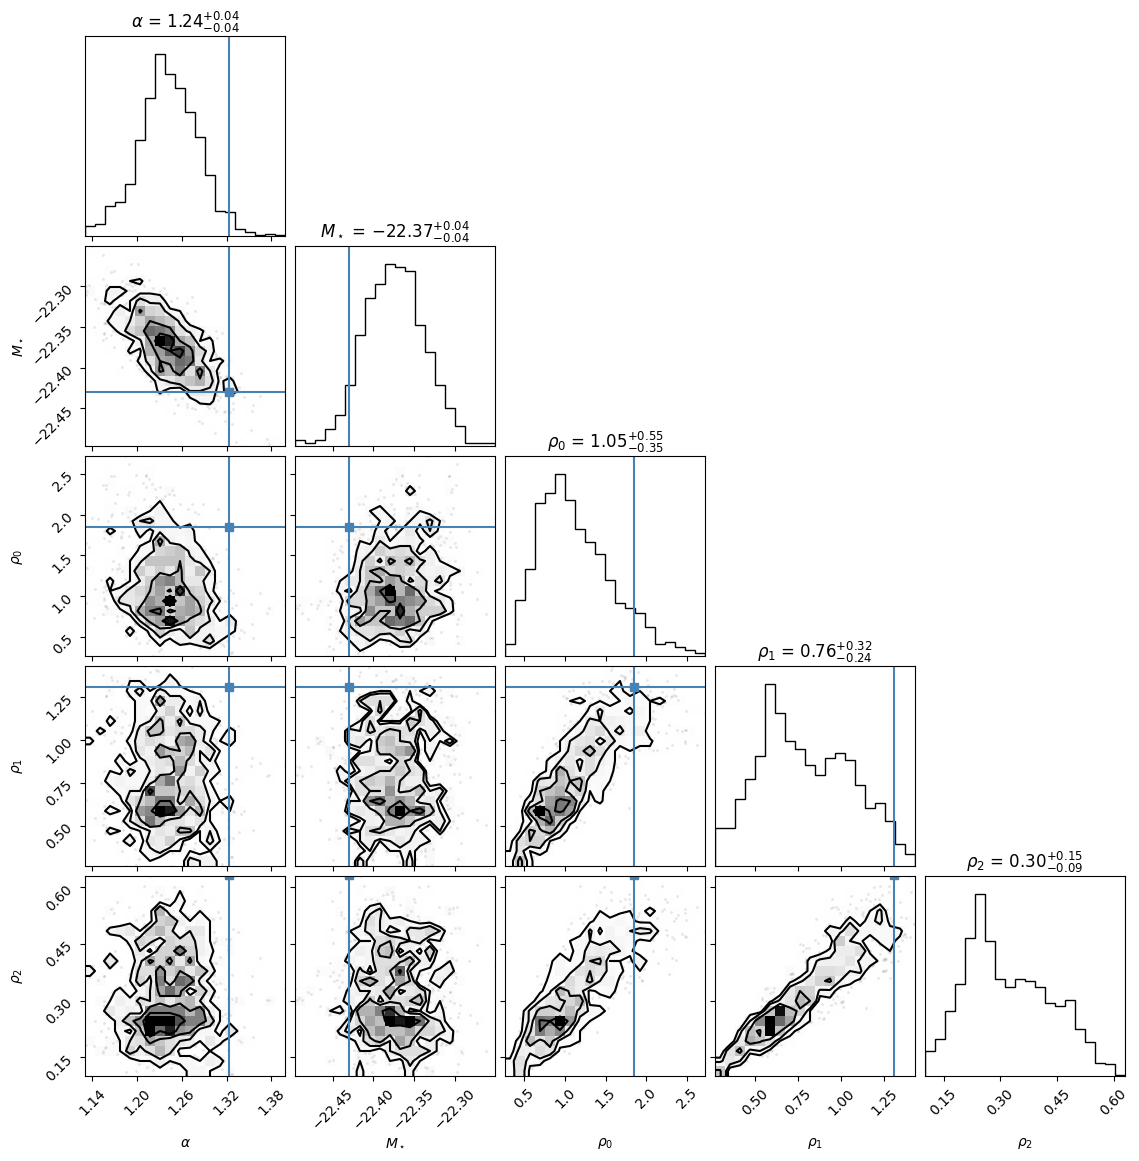

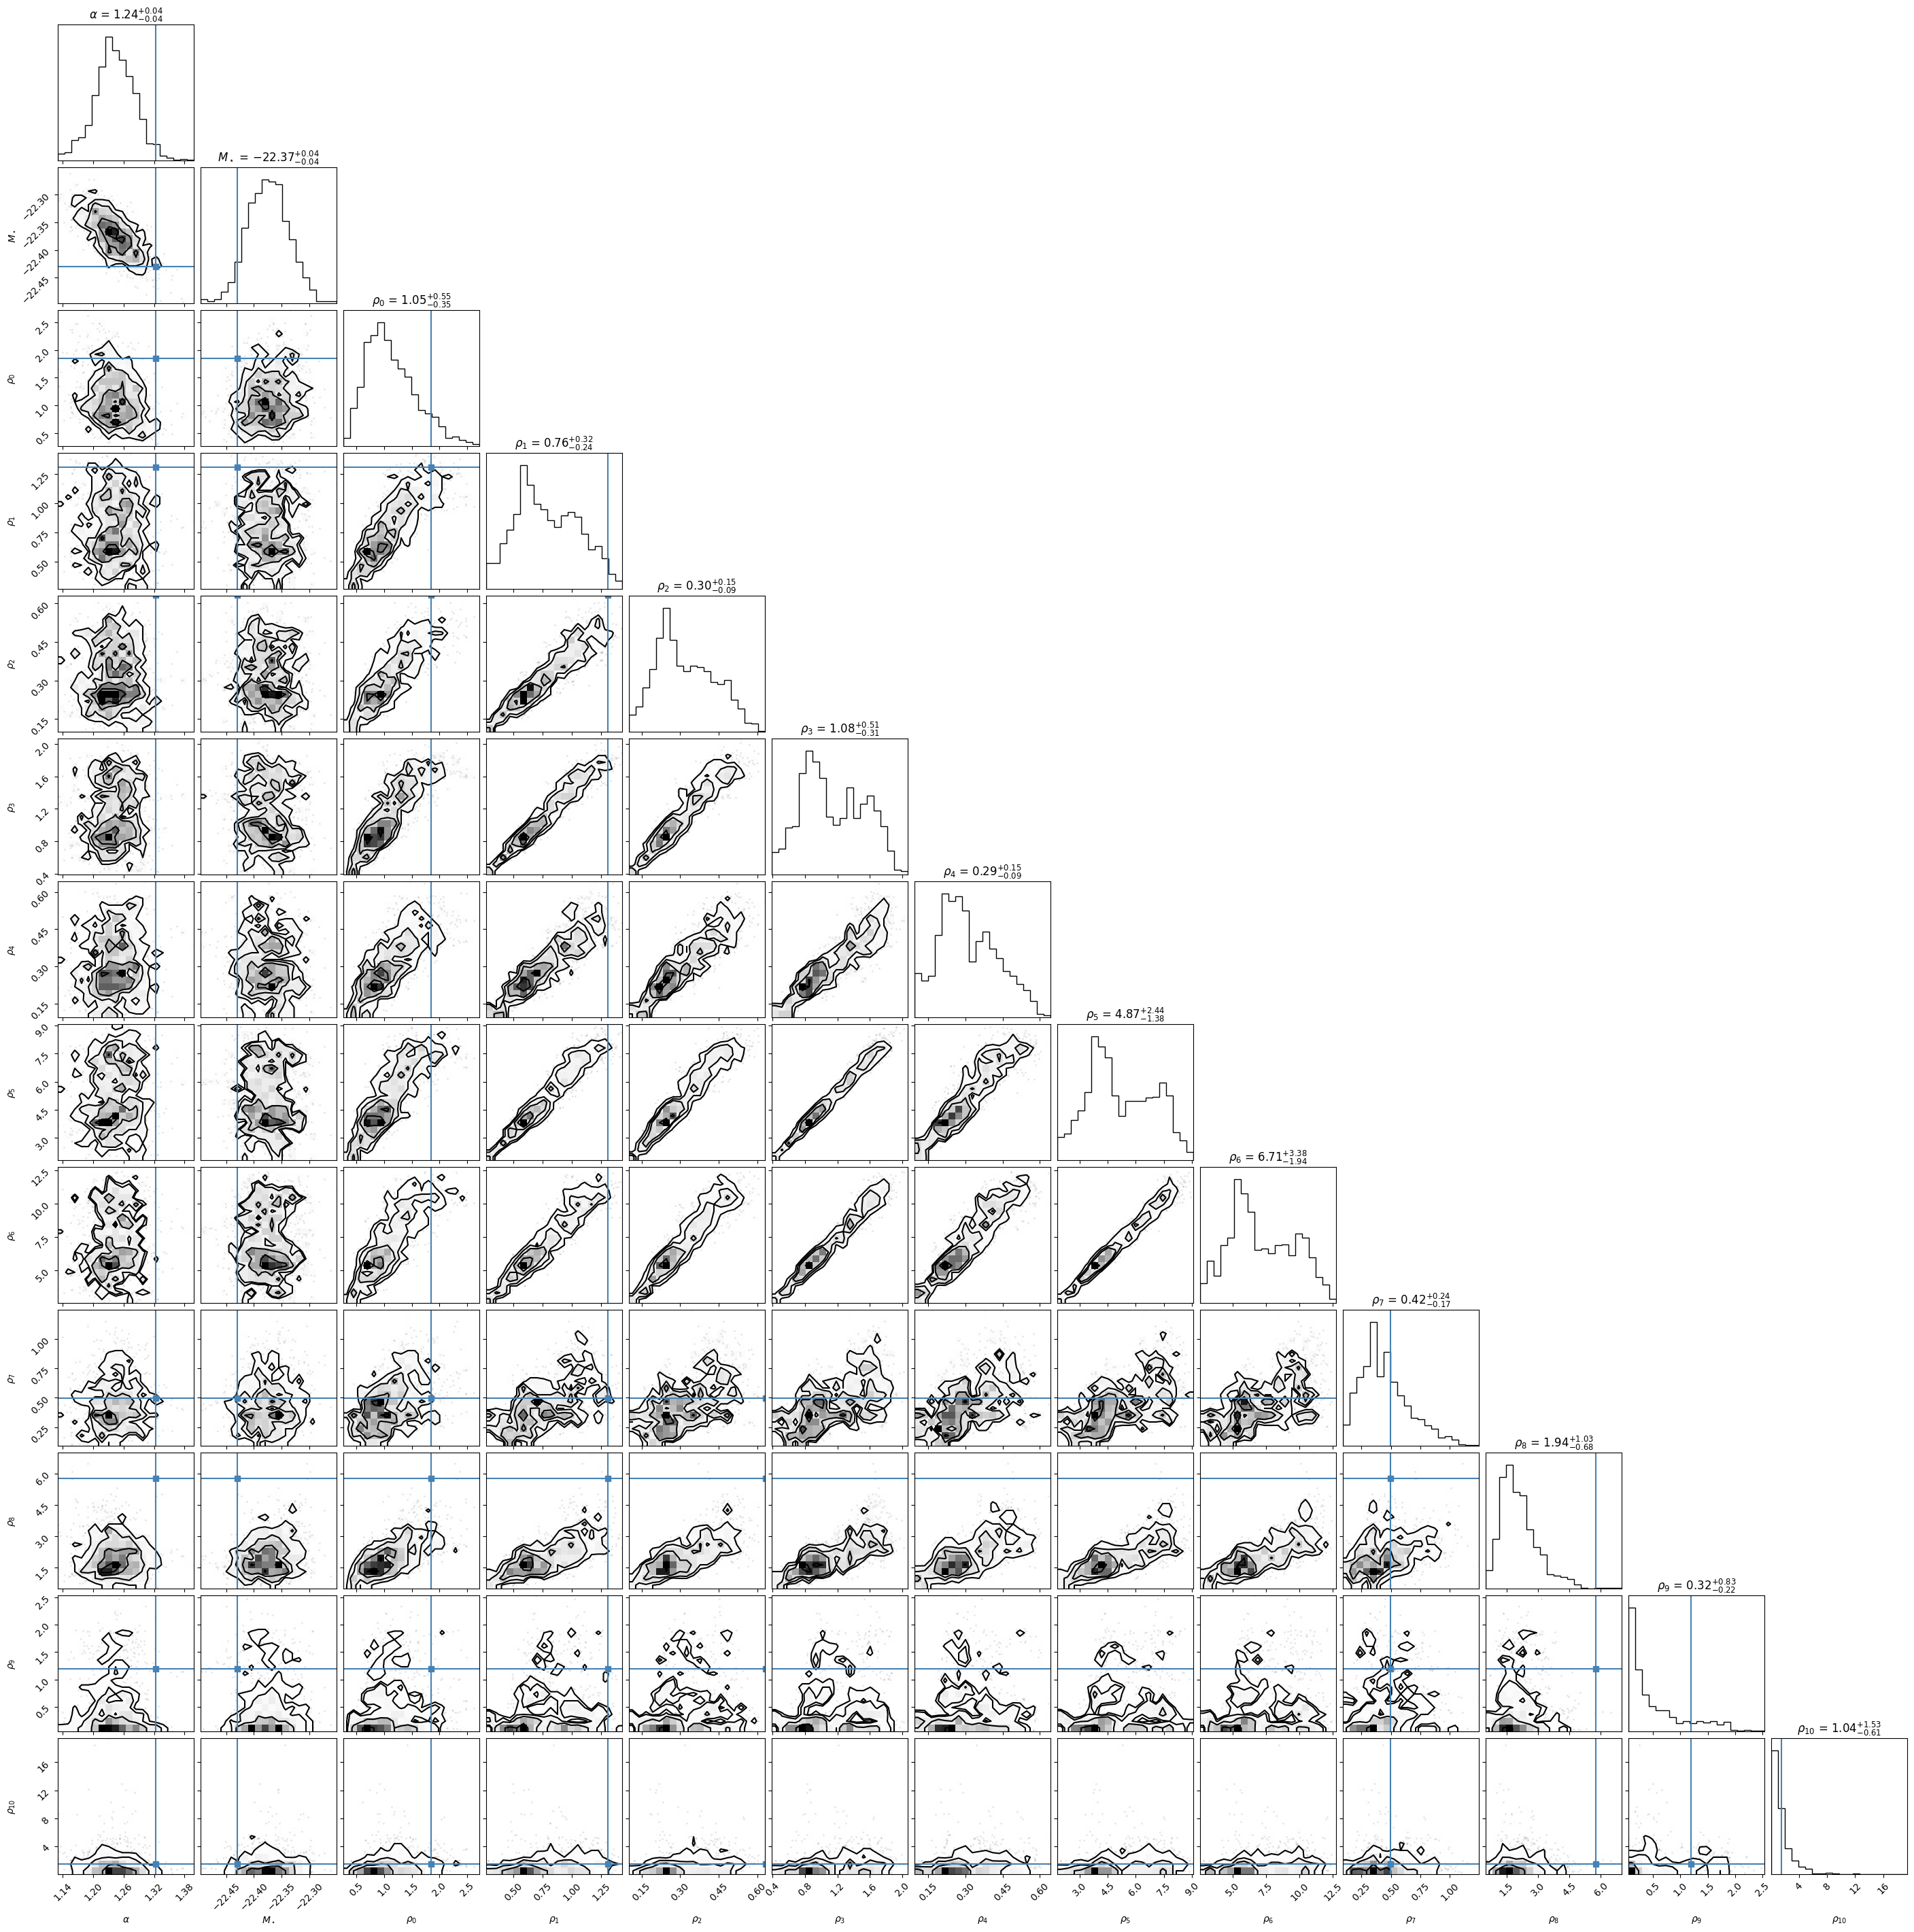

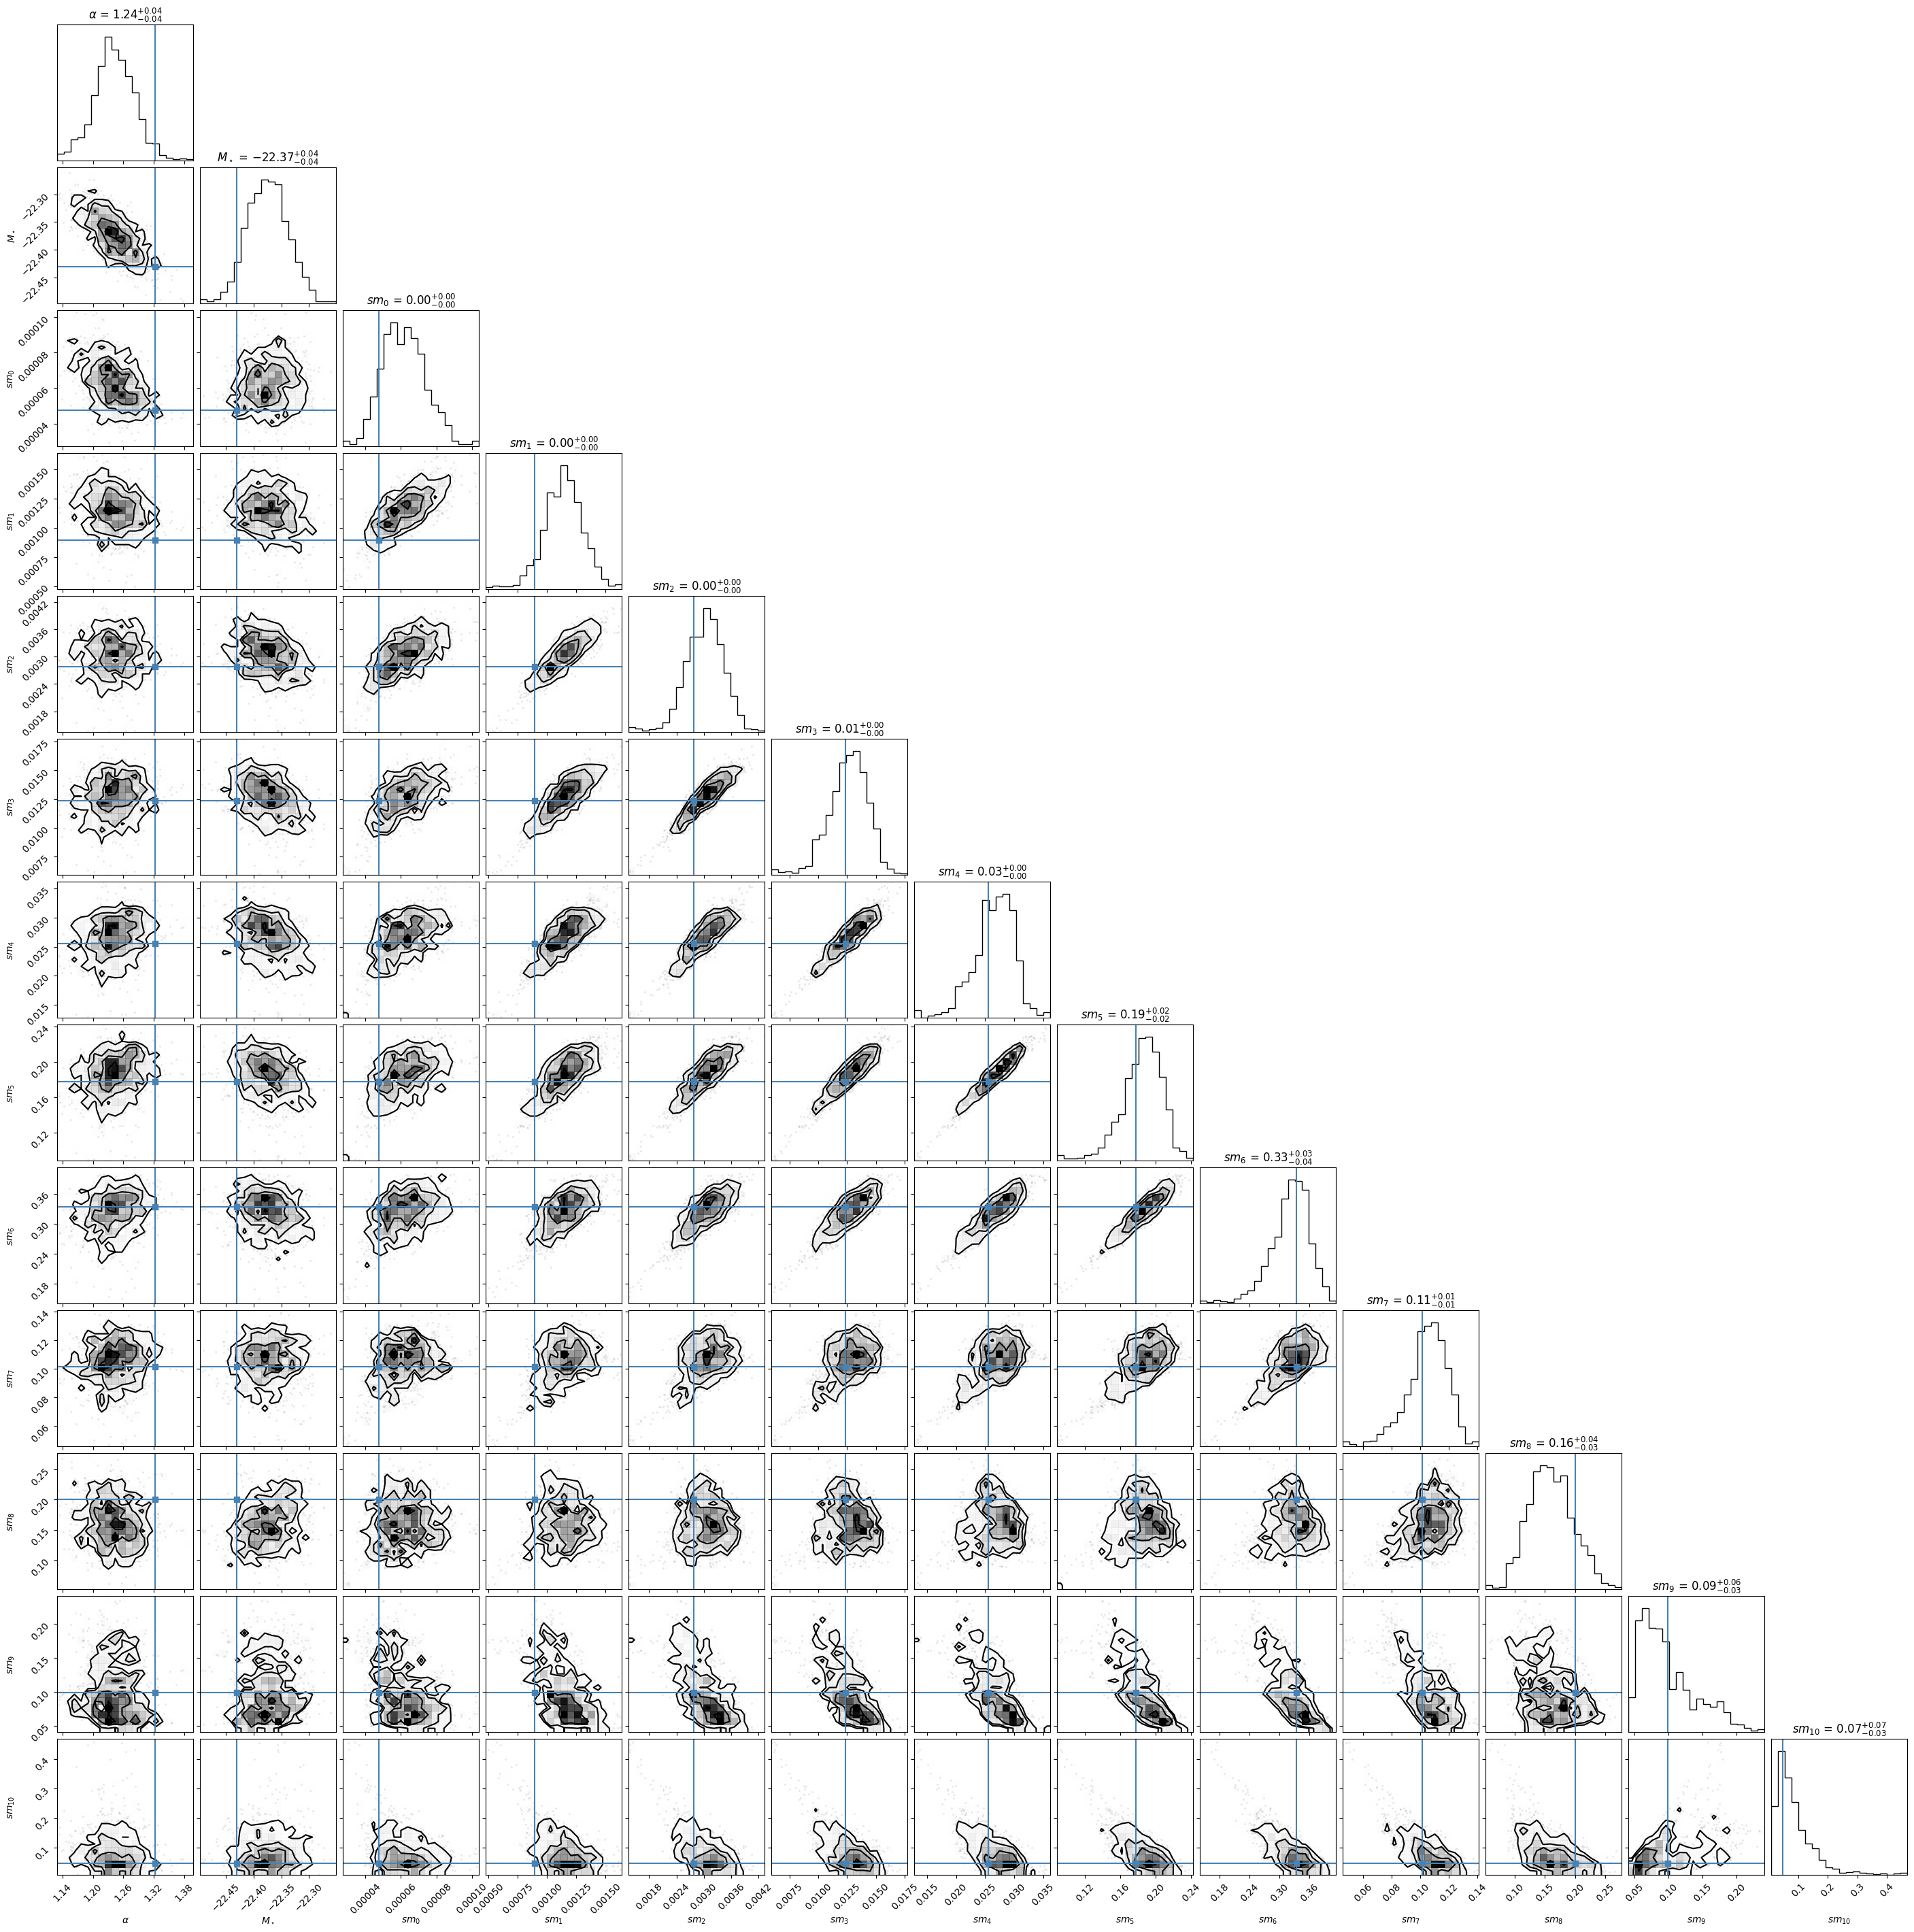

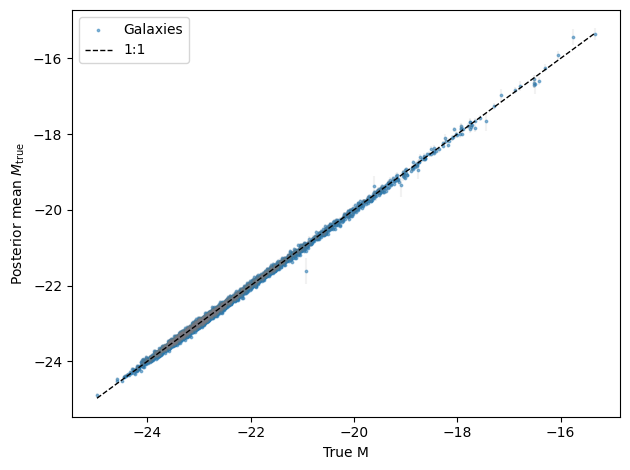

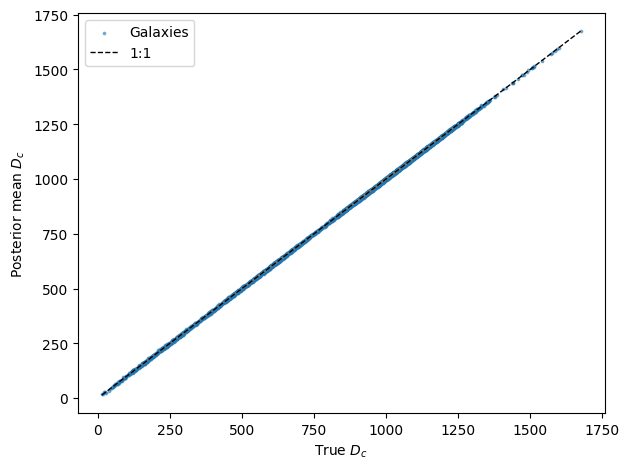

In [10]:
import matplotlib.pyplot as plt
import corner
import arviz as az
import seaborn as sns

res = az.from_numpyro(mcmc)


## corner with alpha, M* and some rho_pts
posterior = res.posterior

# Get shapes
# alpha: (chain, draw)
alpha_samps = posterior['alpha'].values.reshape(-1)        # (n_samples,)
M_star_samps = posterior['M_star'].values.reshape(-1)      # (n_samples,)

# rho_pts: (chain, draw, n_knots)
rho_samps = posterior['rho_pts'].values                     # (chain, draw, n_knots)
rho_samps_flat = rho_samps.reshape(-1, rho_samps.shape[-1])      # (n_samples, n_knots)

# Pick first 3 knots, for example
rho0 = rho_samps_flat[:, 0]
rho1 = rho_samps_flat[:, 1]
rho2 = rho_samps_flat[:, 2]

# Stack into a single samples array for corner: (n_samples, n_params)
subset = np.column_stack([alpha_samps, M_star_samps, rho0, rho1, rho2])

labels = [r"$\alpha$", r"$M_\star$", r"$\rho_0$", r"$\rho_1$", r"$\rho_2$"]

fig = corner.corner(
    subset,
    labels=labels,
    show_titles=True,
    truths=[alpha, M_star, rho_pts_ground[0], rho_pts_ground[1], rho_pts_ground[2]],
)

plt.show()




## corner with all f_pts
# extract f_pts: shape (chain, draw, n_knots)
rho_da = res.posterior["rho_pts"]        # xarray DataArray
rho_vals_corner = rho_da.values                    # numpy array

# flatten chains and draws → (n_samples, n_knots)
n_chains, n_draws, n_knots = rho_vals_corner.shape
rho_flat = rho_vals_corner.reshape(n_chains * n_draws, n_knots)
corner_data = np.column_stack([alpha_samps, M_star_samps, rho_flat])


# nice labels: f_0, f_1, ..., f_{n_knots-1}
labels = [r"$\alpha$", r"$M_\star$"] + [fr"$\rho_{{{i}}}$" for i in range(n_splines)]
alpha_arr = np.atleast_1d(float(alpha))
M_star_arr = np.asarray(M_star).ravel()
rho_arr = np.asarray(rho_pts_ground).ravel()
truths = np.concatenate([alpha_arr, M_star_arr, rho_arr])

fig = corner.corner(
    corner_data,
    labels=labels,
    show_titles=True,
    truths=truths
)

plt.show()


## corner with all shell mass
# extract shell mass: shape (chain, draw, n_knots)
sm_da = res.posterior["shell_mass"]        # xarray DataArray
sm_vals_corner = sm_da.values                    # numpy array

# flatten chains and draws → (n_samples, n_knots)
n_chains, n_draws, n_knots = sm_vals_corner.shape
sm_flat = sm_vals_corner.reshape(n_chains * n_draws, n_knots)
corner_data = np.column_stack([alpha_samps, M_star_samps, sm_flat])


# nice labels: f_0, f_1, ..., f_{n_knots-1}
labels = [r"$\alpha$", r"$M_\star$"] + [fr"$sm_{{{i}}}$" for i in range(n_splines)]
alpha_arr = np.atleast_1d(float(alpha))
M_star_arr = np.asarray(M_star).ravel()
sm_arr = np.asarray(shell_mass_ground).ravel()
truths = np.concatenate([alpha_arr, M_star_arr, sm_arr])

fig = corner.corner(
    corner_data,
    labels=labels,
    show_titles=True,
    truths=truths
    )

plt.show()




M_samples = posterior['M_true'].values
M_mean = M_samples.mean(axis=(0,1))

M_lower = np.percentile(M_samples, 16, axis=(0, 1))
M_upper = np.percentile(M_samples, 84, axis=(0, 1))

plt.scatter(M_ground, M_mean, s=3, alpha=0.5, label='Galaxies')

plt.errorbar(M_ground, M_mean,
             yerr=[M_mean - M_lower, M_upper - M_mean],
             fmt="none", ecolor="gray", alpha=0.1)

mn = min(M_ground.min(), M_mean.min())
mx = max(M_ground.max(), M_mean.max())
plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1, color="k", label="1:1")

plt.xlabel(r"True M")
plt.ylabel(r"Posterior mean $M_{\mathrm{true}}$")
plt.legend()
plt.tight_layout()
plt.show()



dc_samples = posterior['d_c_true'].values
dc_mean = dc_samples.mean(axis=(0,1))

dc_lower = np.percentile(dc_samples, 16, axis=(0, 1))
dc_upper = np.percentile(dc_samples, 84, axis=(0, 1))

plt.scatter(d_c_ground, dc_mean, s=3, alpha=0.5, label='Galaxies')

plt.errorbar(d_c_ground, dc_mean,
             yerr=[dc_mean - dc_lower, dc_upper - dc_mean],
             fmt="none", ecolor="gray", alpha=0.1)

mn = min(d_c_ground.min(), dc_mean.min())
mx = max(d_c_ground.max(), dc_mean.max())
plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1, color="k", label="1:1")

plt.xlabel(r"True $D_c$")
plt.ylabel(r"Posterior mean $D_c$")
plt.legend()
plt.tight_layout()
plt.show()


# plt.plot(r_points, rho_pts_ground)
# plt.plot(r_points, np.mean(f_flat, axis=0))
# plt.yscale('log')
# plt.show()

# f_vals_mcmc = f_of_r(r_vals, np.mean(f_samps_flat, axis=0))

# plt.plot(r_vals, f_vals_ground, label='True rho(r)')
# plt.plot(r_vals, f_vals_mcmc, label='Sampled rho(r)')
# plt.yscale('log')
# plt.title("rho(r) ground vs rho(r) mcmc comparison")
# plt.xlabel(r'$D_c$')
# plt.ylabel('log(rho)')
# plt.legend()
# plt.show()


# sns.histplot(samples['alpha'], stat='density', bins='auto', color='skyblue')
# sns.kdeplot(samples['alpha'])
# plt.title('Alpha posterior - wider integral, fewer grid points')
# plt.show()

# sns.histplot(samples['M_star'], stat='density', bins='auto', color='skyblue')
# sns.kdeplot(samples['M_star'])
# plt.title('M_star posterior - wider integral, fewer grid points')
# plt.show()

# sns.histplot(samples['psi'], stat='density', bins='auto', color='skyblue')
# sns.kdeplot(samples['psi'])
# plt.title('Psi posterior - wider integral, fewer grid points')
# plt.show()

### Reconstruction of $\rho(r)$ with uncertainty bands

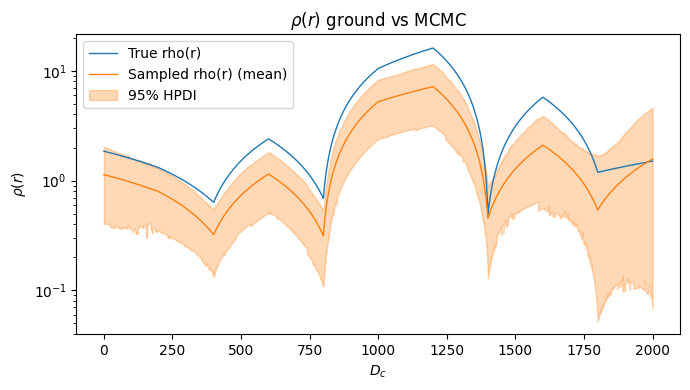

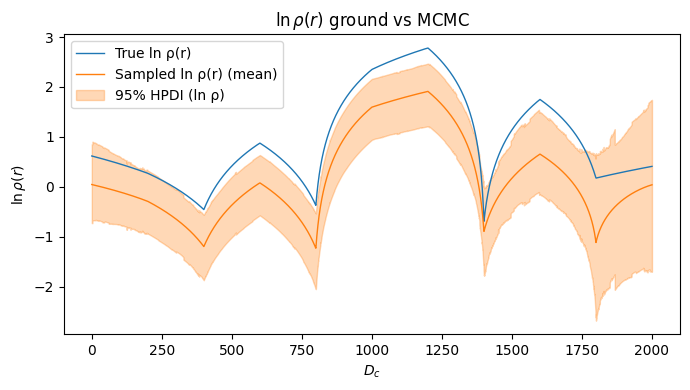

In [11]:
from numpyro.diagnostics import hpdi

# Posterior samples of the spline control points
# shape: (n_samples, n_splines)
f_samps = np.array(samples["rho_pts"])

# Evaluate rho(r) on r_vals for each posterior sample
f_samps_jax = jnp.array(f_samps)  # to JAX
r_vals_jax  = jnp.array(r_vals)

# vmap over the samples: (n_samples, n_splines) -> (n_samples, n_r)
f_vals_samps = vmap(lambda f_pts: f_of_r(r_vals_jax, f_pts))(f_samps_jax)

# Posterior mean and 95% HPDI at each r
fmean = jnp.mean(f_vals_samps, axis=0)
hpdi_f = hpdi(f_vals_samps, prob=0.95)   # shape (2, n_r)

# Convert to numpy for plotting
fmean_np   = np.array(fmean)
hpdi_f_low = np.array(hpdi_f[0])
hpdi_f_hi  = np.array(hpdi_f[1])

plt.figure(figsize=(7, 4))
plt.plot(r_vals, rho_grid_ground, label='True rho(r)', color='C0', lw=1)
plt.plot(r_vals, fmean_np, label='Sampled rho(r) (mean)', color='C1', lw=1)

# Uncertainty band
plt.fill_between(
    r_vals,
    hpdi_f_low,
    hpdi_f_hi,
    color='C1',
    alpha=0.3,
    interpolate=True,
    label='95% HPDI'
)

plt.yscale('log')
plt.title(r"$\rho(r)$ ground vs MCMC")
plt.xlabel(r'$D_c$')
plt.ylabel(r'$\rho(r)$')
plt.legend()
plt.tight_layout()
plt.show()


## alternative version with ln(rho(r)) plotted with linear axis

# Posterior samples of the spline control points
# shape: (n_samples, n_splines)
f_samps = np.array(samples["rho_pts"])

# Convert to JAX
f_samps_jax = jnp.array(f_samps)   # (n_samples, n_splines)
r_vals_jax  = jnp.array(r_vals)    # (n_r,)

# Evaluate rho(r) on r_vals for each posterior sample
# f_of_r(r, f_pts) should already be defined and JAX-compatible
f_vals_samps = vmap(lambda f_pts: f_of_r(r_vals_jax, f_pts))(f_samps_jax)  # (n_samples, n_r)

# To avoid log(0), add a tiny epsilon
eps = 1e-30
log_f_vals_samps = jnp.log(f_vals_samps + eps)  # ln rho(r)

# Posterior mean and 95% HPDI in log space
log_fmean = jnp.mean(log_f_vals_samps, axis=0)         # (n_r,)
log_hpdi  = hpdi(log_f_vals_samps, prob=0.95)          # (2, n_r)

# Convert to numpy for plotting
log_fmean_np   = np.array(log_fmean)
log_hpdi_low   = np.array(log_hpdi[0])
log_hpdi_high  = np.array(log_hpdi[1])

# True profile in log-space
log_rho_ground  = np.log(rho_grid_ground + eps)

# Plot ln rho(r) vs r
plt.figure(figsize=(7, 4))

plt.plot(r_vals, log_rho_ground, label='True ln ρ(r)', color='C0', lw=1)
plt.plot(r_vals, log_fmean_np, label='Sampled ln ρ(r) (mean)', color='C1', lw=1)

plt.fill_between(
    r_vals,
    log_hpdi_low,
    log_hpdi_high,
    color='C1',
    alpha=0.3,
    interpolate=True,
    label='95% HPDI (ln ρ)'
)

plt.title(r"$\ln \rho(r)$ ground vs MCMC")
plt.xlabel(r'$D_c$')
plt.ylabel(r'$\ln \rho(r)$')
plt.legend()
plt.tight_layout()
plt.show()